# Model Evaluation

Model evaluation is a crucial step to validate how well the trained model performs to the data that have not seen before.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the Breast Cancer Dataset

You can download the breast cancer dataset [here](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/).

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.iloc[:, 2:].to_numpy()
y = df.iloc[:, 1].to_numpy()
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## Import Pipeline Class for efficient workflow

Pipeline class allows to put transformer objects and an estimator object into a single pipeline, so that the preprocessing and learning steps can be done together in just a few lines of code.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.pipeline import make_pipeline

lr_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LR(random_state=1)
)

lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)
print('Test accuracy: %.3f' % lr_pipe.score(X_test, y_test))

Test accuracy: 0.956


In [27]:
from sklearn import set_config
set_config(display='diagram')
print(lr_pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression',
                 LogisticRegression(C=100.0, random_state=1))])


## Evaluate the model using K-Fold Cross-Validation

A **k-fold cross-validation** randomly divides the dataset (mostly the training data) into $k$ folds without repetition. $k-1$ folds are utilized to train the model and a leftover fold is used to evaluate the model performance. Repeat this process $k$ times to have $k$ different model evaluations. Finally, k-fold cross-validation computes the mean of $k$ different model evaluations and outputs final model performance.

- $P = {1 \over k} \sum_{i=1}^kE_i$ where $P$ is the final model performance and $E_i$ is the *i*-th model evaluation.

In [6]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for i, (train, test) in enumerate(kfold):
    lr_pipe.fit(X_train[train], y_train[train])
    score = lr_pipe.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold %2d, Stratification: %s, Accuracy: %.3f' % (i+1, np.bincount(y_train[train]), score))

Fold  1, Stratification: [256 153], Accuracy: 0.935
Fold  2, Stratification: [256 153], Accuracy: 0.935
Fold  3, Stratification: [256 153], Accuracy: 0.957
Fold  4, Stratification: [256 153], Accuracy: 0.957
Fold  5, Stratification: [256 153], Accuracy: 0.935
Fold  6, Stratification: [257 153], Accuracy: 0.956
Fold  7, Stratification: [257 153], Accuracy: 0.978
Fold  8, Stratification: [257 153], Accuracy: 0.933
Fold  9, Stratification: [257 153], Accuracy: 0.956
Fold 10, Stratification: [257 153], Accuracy: 0.956


In [7]:
print('k-fold cross-validation mean accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Stratified k-fold cross-validation accuracy: 0.950 +/- 0.014


In [8]:
# another way to calculate stratified k-fold cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('k-fold cross-validation scores: \n%s' % scores)

Array of stratified k-fold cross-validation scores: 
[0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


In [9]:
print('k-fold cross-validation mean accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Stratified k-fold cross-validation accuracy: 0.950 +/- 0.014


## Learning and Validation Curves

There are two powerful curves for debugging:
- **Learning curve** indicates whether the model has a problem of high variation or bias based on plotting the training and validation accuracy vs. the number of training data. This curve also tells the potential risk of overfitting when the training samples are below the threshold value.

- **Validation curve** on the other hand, uses the range of model parameter instead of the number of training samples to identify whether the model is underfitting or overfitting to the training data. It finds the best value range of parameter to make the model perform better.

In [10]:
from sklearn.model_selection import learning_curve

lr_pipe = make_pipeline(
    StandardScaler(),
    LR(penalty='l2', random_state=1)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=lr_pipe,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=-1
)

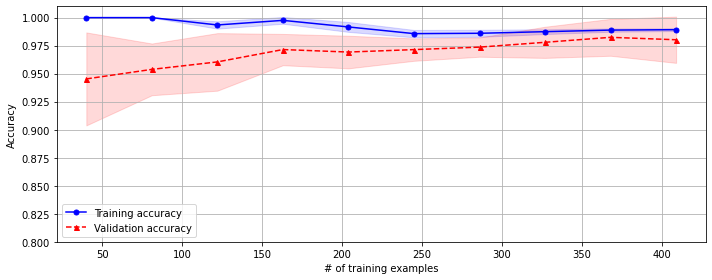

In [13]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(train_sizes, mean_train_scores, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, mean_train_scores + std_train_scores, mean_train_scores - std_train_scores, alpha=0.15, color='blue')
plt.plot(train_sizes, mean_test_scores, linestyle='--', color='red', marker='^', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, mean_test_scores + std_test_scores, mean_test_scores - std_test_scores, alpha=0.15, color='red')
plt.grid()
plt.legend(loc='best')
plt.xlabel('# of training samples')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.01])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import validation_curve

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(
    estimator=lr_pipe,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10,
    n_jobs=-1
)

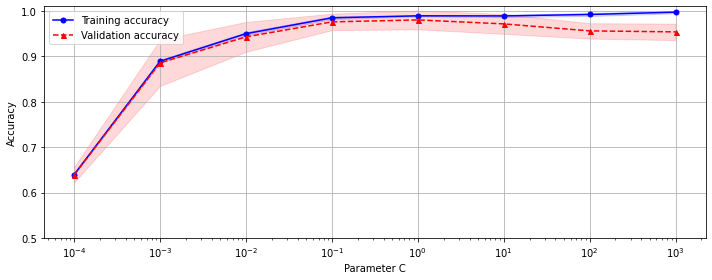

In [17]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(param_range, mean_train_scores, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, mean_train_scores + std_train_scores, mean_train_scores - std_train_scores, alpha=0.15, color='blue')
plt.plot(param_range, mean_test_scores, linestyle='--', color='red', marker='^', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, mean_test_scores + std_test_scores, mean_test_scores - std_test_scores, alpha=0.15, color='red')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.tight_layout()
plt.show()

## Grid Search for Hyperparameter Tuning

Grid search is an exhaustive search method that investigates all possible combinations of parameter values. The parameters of the estimator are optimized by stratified k-fold cross-validated grid search over parameter grid. For more information, visit [scikit-learn.org about GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_pipe = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {
        'svc__C': param_range,
        'svc__kernel': ['linear']
    },
    {
        'svc__C': param_range,
        'svc__gamma': param_range,
        'svc__kernel': ['rbf']
    }
]

gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1
)
gs.fit(X_train, y_train)
print(gs)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                     1000.0],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                     1000.0],
                          'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0, 1000.0],
                          'svc__kernel': ['rbf']}],
             scoring='accuracy')


In [19]:
print(gs.best_score_)

0.9846859903381642


In [20]:
print(gs.best_params_)

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [21]:
best_estimator = gs.best_estimator_
print('Test accuracy: %.3f' % best_estimator.score(X_test, y_test))

Test accuracy: 0.974


## Model Evaluation Metrics

Confusion matrix is a squared matrix that indicates the number of **True Positive** (TP), **True Negative** (TN), **False Positive** (FP) and **False Negative** (FN) samples.

In [22]:
from sklearn.metrics import confusion_matrix

svc_pipe.fit(X_train, y_train)
y_pred = svc_pipe.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


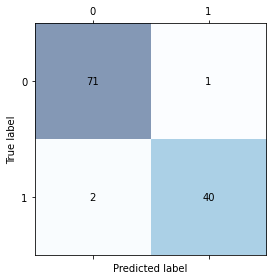

In [23]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(i, j, s=confmat[j, i], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

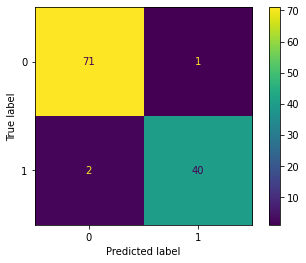

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(svc_pipe, X_test, y_test)
plt.show()

Computations for each metric are as follows:
- Accuarcy, $ACC = {{TP + TN}\over{FP + FN + TP + TN}}$
- False Positive Rate, $FPR = {FP\over{FP + TN}}$
- True Positive Rate, $TPR = {TP\over{FN + TP}}$
- Precision, $PRE = {TP\over{TP + FP}}$
- Recall, $REC = TPR = {TP\over{FN + TP}}$
- F1, $F1 = 2 {{PRE * REC}\over{PRE + REC}}$

In [25]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)

print('Accuracy score: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision score: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall score: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1 score: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Accuracy score: 0.974
Precision score: 0.976
Recall score: 0.952
F1 score: 0.964


Quoting from [scikit-learn.org about Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics): "Receiver Operating Characteristic is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the TPR vs. FPR, at various threshold settings." In addition, visit [scikit-learn.org about RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html) for more information about the RocCurveDisplay class.

Computing the area under the ROC curve (ROC AUC) can quantitatively evaluate the overall classification model performance.

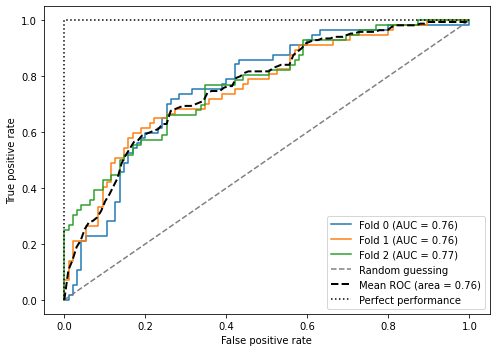

In [26]:
# ROC Curve and ROC AUC (Area Under Curve)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from numpy import interp

lr_pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LR(penalty='l2', C=100.0, random_state=1)
)

roc_X = X_train[:, [4, 14]]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(X_train, y_train)

fig, ax = plt.subplots(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    lr_pipe.fit(roc_X[train], y_train[train])
    roc = RocCurveDisplay.from_estimator(lr_pipe, roc_X[test], y_train[test], name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc.fpr, roc.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guessing')
mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, linestyle='--', color='black', label='Mean ROC (area = %.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.tight_layout()
plt.show()